## Obtendo o ponto do lote para conectar a rede

In [1]:
import geopandas as gpd

In [2]:
gdf_lotes = gpd.read_file('gis-data/moema-passaros.gpkg', layer='lotes')

/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
gdf_quadras_prediais = gpd.read_file('gis-data/moema-passaros.gpkg', layer='quadras-prediais')

<AxesSubplot:>

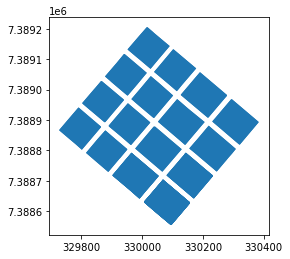

In [4]:
gdf_quadras_prediais.buffer(-1).plot()

In [5]:
gdf_lote_porta = \
gdf_lotes.difference(gdf_quadras_prediais.buffer(-1).unary_union).representative_point()

<AxesSubplot:>

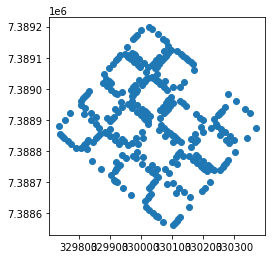

In [6]:
gdf_lote_porta.plot()

In [7]:
gdf_lote_porta.to_file('gis-data/moema-passaros-lote-porta.gpkg', driver='GPKG')

## Conectar o ponto do lote à rede

In [280]:
from shapely.ops import nearest_points
from shapely.geometry import LineString, MultiLineString, Point

In [9]:
gdf_eixos_mediais = gpd.read_file('gis-data/moema-passaros.gpkg', layer='eixos-mediais')

/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


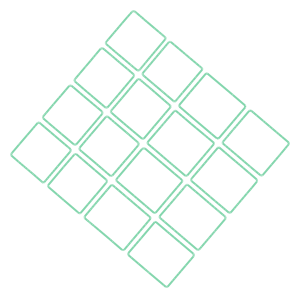

In [10]:
gdf_eixos_mediais.unary_union

In [11]:
gdf_ponto_lote_rede = \
gdf_lote_porta[~gdf_lote_porta.is_empty].apply(lambda x: nearest_points(x, gdf_eixos_mediais.unary_union))

<AxesSubplot:>

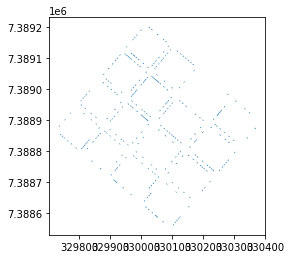

In [12]:
gpd.GeoDataFrame(geometry=gdf_ponto_lote_rede.apply(lambda x: LineString(x))).plot()

In [13]:
gpd.GeoDataFrame(geometry=gdf_ponto_lote_rede.apply(lambda x: LineString(x))).to_file('gis-data/moema-passaros-lote-porta.gpkg', layer='segmento-de-rede')

## Conectando os eixos mediais com travesia dos logradouros

In [244]:
from shapely.ops import linemerge

In [245]:
gdf_poligono_de_via = \
gpd.read_file('gis-data/moema-passaros.gpkg', layer='poligono-de-vias')

/home/fernando/miniconda3/envs/geoplot/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [246]:
gdf_quadras_viarias = \
gpd.read_file('gis-data/moema-passaros.gpkg', layer='quadras-viarias')

In [253]:
seila = gdf_poligono_de_via.intersection(gdf_quadras_viarias.buffer(0.5).boundary.unary_union)

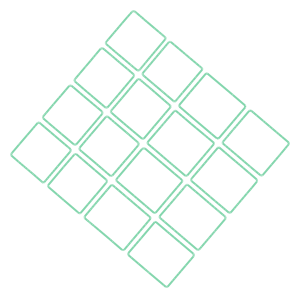

In [274]:
# gpd.sjoin(gdf_poligono_de_via, gdf_quadras_viarias, op='intersects', how='right')
gdf_eixos_mediais.unary_union

<AxesSubplot:>

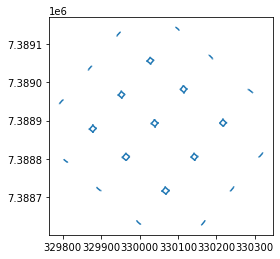

In [317]:
def connect_sides(x):
    lm = linemerge(x)
    eixos = gdf_eixos_mediais.unary_union
    
    if lm.geom_type == 'MultiLineString':
#         print(list(lm.geoms)[0].coords[:][-1])
        return MultiLineString([LineString([list(lm.geoms)[0].coords[:][0], list(lm.geoms)[1].coords[:][-1]]),\
                               LineString([list(lm.geoms)[1].coords[:][0], list(lm.geoms)[0].coords[:][-1]]),\
                               LineString(nearest_points(Point(list(lm.geoms)[0].coords[:][0]), eixos)),\
                                LineString(nearest_points(Point(list(lm.geoms)[0].coords[:][-1]), eixos)),\
                                LineString(nearest_points(Point(list(lm.geoms)[1].coords[:][-1]), eixos)),\
                               LineString(nearest_points(Point(list(lm.geoms)[1].coords[:][0]), eixos))])
#         return LineString(nearest_points(Point(list(lm.geoms)[0].coords[:][0]), eixos))
    return None

seila.apply(lambda x: connect_sides(x)).plot()

In [319]:
seila.apply(lambda x: connect_sides(x)).to_file('gis-data/moema-passaros-lote-porta.gpkg', layer='travessias', driver='GPKG')